In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## STEP 1: Read in the data

In [3]:
num_of_chunk = 0
chunksize = 10 ** 6

train = pd.DataFrame()
    
for chunk in pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/train.gz', sep = ",", chunksize=chunksize):
    num_of_chunk += 1
    train = pd.concat([train, chunk.sample(frac=.01, replace=False, random_state=123)], axis=0) # >= chunk.sample(frac = .002)
    print('Processing Chunk No. ' + str(num_of_chunk))     
    
train.reset_index(inplace=True)

# Create a back-up file for the length of the training set
train_len = len(train)
train_len

Processing Chunk No. 1
Processing Chunk No. 2
Processing Chunk No. 3
Processing Chunk No. 4
Processing Chunk No. 5
Processing Chunk No. 6
Processing Chunk No. 7
Processing Chunk No. 8
Processing Chunk No. 9
Processing Chunk No. 10
Processing Chunk No. 11
Processing Chunk No. 12
Processing Chunk No. 13
Processing Chunk No. 14
Processing Chunk No. 15
Processing Chunk No. 16
Processing Chunk No. 17
Processing Chunk No. 18
Processing Chunk No. 19
Processing Chunk No. 20
Processing Chunk No. 21
Processing Chunk No. 22
Processing Chunk No. 23
Processing Chunk No. 24
Processing Chunk No. 25
Processing Chunk No. 26
Processing Chunk No. 27
Processing Chunk No. 28
Processing Chunk No. 29
Processing Chunk No. 30
Processing Chunk No. 31
Processing Chunk No. 32
Processing Chunk No. 33
Processing Chunk No. 34
Processing Chunk No. 35
Processing Chunk No. 36
Processing Chunk No. 37
Processing Chunk No. 38
Processing Chunk No. 39
Processing Chunk No. 40
Processing Chunk No. 41


404290

In [4]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kaggle/test.gz', sep = ",", delimiter=',',dtype={'id': str})

In [5]:
# Undersample to recreate a balanced training set
x_train = train[train['click'] == 0].sample(n=len(train[train['click'] == 1]), random_state=111)
x_train = pd.concat([x_train, train[train['click'] == 1]]).sample(frac=1)
y_train = x_train[['click']]
x_train.drop(['click'], axis=1, inplace=True)
x_test = test

In [6]:
# concat the test dataset and train dataset, drop the id column
df1 = pd.concat([x_train,x_test],axis = 0, ignore_index = True).drop("id",1)

## STEP 2: Exploratory Data Analysis (EDA)

### 2-1. Correlations (Brief)

In [7]:
#lets create heatmap first of all lest see on which feature SalePrice is dependent
abs_corr_with_y = abs(train.corr()["click"]).sort_values(ascending=False).round(2)
print(abs_corr_with_y)

click               1.00
C16                 0.13
device_conn_type    0.09
C21                 0.07
C14                 0.06
C20                 0.06
C17                 0.06
device_type         0.04
C1                  0.04
C15                 0.03
banner_pos          0.03
C18                 0.02
index               0.01
hour                0.01
C19                 0.00
id                  0.00
Name: click, dtype: float64


### 2-2. First let's take a look at the structure of the datasets(dtypes, value_counts, null_counts)

In [8]:
print(f"the dataset consists of {df1.shape[0]} rows and {df1.shape[1]} cols\n-------------------------------------------")
print(pd.DataFrame({"data_types":df1.dtypes, 
                    "value_counts": df1.nunique(),
                   "null_counts": df1.isnull().sum()}).set_index(df1.dtypes.index).
      sort_values(by = "value_counts", ascending = False))

df1.head()

the dataset consists of 4715238 rows and 23 cols
-------------------------------------------
                 data_types  value_counts  null_counts
device_ip            object       1145740            0
device_id            object        311974            0
index               float64        137774      4577464
device_model         object          5564            0
app_id               object          4243            0
site_domain          object          3504            0
site_id              object          2978            0
C14                   int64          2267            0
C17                   int64           456            0
hour                  int64           264            0
app_domain           object           225            0
C20                   int64           165            0
C19                   int64            67            0
C21                   int64            62            0
app_category         object            29            0
site_category        object

,index,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,35870295.0,14102920,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,a99f214a,33ad8d0b,7b7ca585,1,0,17017,320,50,1873,3,39,-1,23
1,32738319.0,14102903,1005,1,3dc2d6de,e2a5dc06,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,2456777f,eba9519f,1,0,22680,320,50,2528,0,39,100081,221
2,35892757.0,14102920,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,9f1bf14d,7abbbd5c,1,0,23723,320,50,2716,3,47,-1,23
3,36224949.0,14103000,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,13966a32,0b188ab3,1,0,23725,320,50,2716,3,47,-1,23
4,1562549.0,14102107,1005,0,85f751fd,c4e18dd6,50e219e0,422da614,2347f47a,0f2161f8,a99f214a,01fa34f2,42de6880,1,0,21660,320,50,2446,3,171,100228,156


## STEP 3: Feature Engineering
Data are pretty clean, as there is no missing values

### 3-1. Transform the "hour" column
As pointed out by Akishen, we are predicting the CTR in the 11th day using the past 10 days traffic, thus leaving "month"&"year" meaningless.

In [9]:
# hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
from datetime import datetime
# Get the dayzone (generating 4 fields with every 6 hour within a day)
def hour_to_dayzone(hour):
    '''
    Input: an string originally from the df1["hour"]
    '''
    hour_int = int(str(hour)[6:8])
    if hour_int >= 0 and hour_int < 6:
        dayzone = "early_morning"
    elif hour_int >= 6 and hour_int < 12:
        dayzone = "morning"
    elif hour_int >= 12 and hour_int < 18:
        dayzone = "afternoon"
    elif hour_int >= 18 and hour_int < 24:
        dayzone = "night"
    return dayzone
    
df1["day_zone"] = df1["hour"].apply(lambda x:hour_to_dayzone(x))

# Get the weekday
df1["week_day"] = df1["hour"].apply(lambda x:(datetime.strptime(str(x)[:6],"%y%m%d").weekday()+1)).astype(str)

df1 = df1.drop("hour",axis = 1)
df1[["day_zone","week_day"]].describe()

,day_zone,week_day
count,4715238,4715238
unique,4,7
top,morning,5
freq,1631392,4588961


### 3-2. Convert all columns to categorical variables
Based on the discussion notes provided by the contest host, "*all numerical measures in this dataset are actually categorical variables*". So first we do the conversion

In [10]:
# convert integer columns to string according to the instructions provided
for col in df1.columns:
    df1[col] = df1[col].astype(str)
print(df1.dtypes)

index               object
C1                  object
banner_pos          object
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         object
device_conn_type    object
C14                 object
C15                 object
C16                 object
C17                 object
C18                 object
C19                 object
C20                 object
C21                 object
day_zone            object
week_day            object
dtype: object


### 3-3. Feature Creation

In [11]:
# create a user_id for counting and bagging purposes, followed by the 4-idiots approach
df1["user_id"] = df1["device_ip"].str.cat(df1["device_model"], sep = "-")

#### Counting features
Counting features include:
• device ip count
• device id count
• user count
• day_zone + week_day count

In [12]:
device_ip_count = df1[:len(x_train)].groupby("device_ip").device_ip.count()
device_id_count = df1[:len(x_train)].groupby("device_id").device_id.count()
day_zone_count = df1[:len(x_train)].groupby("day_zone").day_zone.count()
week_day_count = df1[:len(x_train)].groupby("week_day").week_day.count()
user_id_count = df1[:len(x_train)].groupby("user_id").user_id.count()

def count_imput(df1, col, count_series):
    '''
    This function imputes the count for each categorical value
    Input:
        df1(dataframe), col(column_name), count_series
    '''
    def imput(x):
        try:
            return count_series[x]
        except:
            return 0
    new_col = col + "_count"
    df1[new_col] = list(map(imput, df1[col]))

    

count_imput(df1, "device_ip", device_ip_count)
count_imput(df1, "device_id", device_id_count)
count_imput(df1, "day_zone", day_zone_count)
count_imput(df1, "week_day", week_day_count)
count_imput(df1, "user_id", user_id_count)

In [13]:
df1[["device_ip", "device_id", "day_zone", "week_day", "user_id",
     "device_ip_count", "device_id_count", "day_zone_count", "week_day_count", "user_id_count"]].head(10)

,device_ip,device_id,day_zone,week_day,user_id,device_ip_count,device_id_count,day_zone_count,week_day_count,user_id_count
0,33ad8d0b,a99f214a,night,3,33ad8d0b-7b7ca585,1,114782,23333,30388,1
1,2456777f,a99f214a,early_morning,3,2456777f-eba9519f,2,114782,28703,30388,1
2,9f1bf14d,a99f214a,night,3,9f1bf14d-7abbbd5c,1,114782,23333,30388,1
3,13966a32,a99f214a,early_morning,4,13966a32-0b188ab3,1,114782,28703,27765,1
4,01fa34f2,a99f214a,morning,2,01fa34f2-42de6880,3,114782,41169,31754,3
5,a42edc21,009d61f7,night,4,a42edc21-e5c6e4b1,1,1,23333,27765,1
6,948c4fdb,a99f214a,afternoon,6,948c4fdb-981edffc,2,114782,44569,11685,1
7,6432d8f6,8e1a7bd0,morning,3,6432d8f6-f07e20f8,1,1,41169,30388,1
8,9bd7de5c,a99f214a,morning,3,9bd7de5c-25cfc3c9,1,114782,41169,30388,1
9,1a4ab890,a99f214a,morning,6,1a4ab890-c144e605,1,114782,41169,11685,1


#### Bagging features
For each user, we add bags of features. For example, if we have user1 associated with app id-A and app id-B, and user2 associated with app id-C and app id-D, then we generate an additional feature bag of app id

In [14]:
app_id_bag = df1[:len(x_train)].groupby('user_id')['app_id'].apply(lambda x:x.str.cat(sep=','))
#app_id_bag

In [15]:
# Impute all user_id with corresponding app_id_bag
def imput_bag(x):
    try:
        return app_id_bag[x]
    except:
        return "no_app_id_bags"
df1["app_id_bag"] = list(map(imput_bag, df1["user_id"]))
#df1["app_id_bag"]

#### Click History
We generate a click history feature for users who have device id information, using the value_transform function (because we only have click data for x_train, not for the entire df1, which also consists of x_test)

In [16]:
accum = []
temp_train_with_click = df1[:len(x_train)]
temp_train_with_click["click"] = list(map(str,y_train.click))
hist_clicks = temp_train_with_click.groupby('user_id')['click'].apply(lambda x: x.str.cat(sep='-'))
hist_clicks.head()
#user_hist_clicks = temp_train_with_click.groupby('user_id')["click"].cumsum()
#user_hist_clicks = pd.DataFrame({"user_id":temp_train_with_click.user_id,
#                                "hist_clicks": temp_train_with_click.groupby('user_id')["click"].cumsum()})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


user_id
0001e4a0-fce66524    1
00030c56-496515fa    0
00030c56-981edffc    0
00030c56-9e3836ff    0
000415c7-fce66524    1
Name: click, dtype: object

In [17]:
# Impute all user_id with corresponding app_id_bag
def imput_hist_clicks(x):
    try:
        return hist_clicks[x]
    except:
        return "unknown"
df1["hist_clicks"] = list(map(imput_hist_clicks, df1["user_id"]))
df1["hist_clicks"].value_counts()

unknown          4219511
0                 134466
1                 131382
1-1                16431
0-0                15485
                  ...   
1-1-1-1-1-1-0          7
0-1-1-0-0-0            6
0-0-1-0-1-0            6
0-0-1-0-0-1            6
0-0-0-1-1              5
Name: hist_clicks, Length: 448, dtype: int64

### 3-4. Dimension reduction
Since most variables contain a hugh number of unique values, there is going to be a dimension exclosion if we directly do OHE out of it. Therefore, we shrink the high-dim columns according to their relative click-through frequencies

In [18]:
df1_structure = pd.DataFrame({"data_types":df1.dtypes, 
                    "value_counts": df1.nunique(),
                   "null_counts": df1.isnull().sum()}).set_index(df1.dtypes.index).sort_values(
                by = "value_counts", ascending = False)
print(df1_structure)


                 data_types  value_counts  null_counts
user_id              object       1736337            0
device_ip            object       1145740            0
device_id            object        311974            0
index                object        137775            0
device_model         object          5564            0
app_id               object          4243            0
site_domain          object          3504            0
site_id              object          2978            0
app_id_bag           object          2422            0
C14                  object          2267            0
C17                  object           456            0
hist_clicks          object           448            0
app_domain           object           225            0
C20                  object           165            0
device_ip_count       int64            86            0
C19                  object            67            0
C21                  object            62            0
user_id_co

In [19]:
def get_click_mapping(train, click):
    '''
    Input:
        train (a temporarily split X_training set from concated df, in order to include all the data cleaning steps above)
        click (y from original training set)
    Output:
        ctr_dict (a dictionary for high-dim mapping)
    '''
    ctr_dict = dict()
    col_names = train.columns # executed before adding the click column to avoid including "click" in the for loop
    train.loc[:,"click"] = click
       
    def get_ctr_level(ctr):    
    
        very_high_ctr = train.click.mean() + 0.04 #here I defined 4% greater than mean CTR as the 'very_high_ctr' threshold
        high_ctr = train.click.mean() + 0.02    #here I defined 2% greater than mean CTR as the 'high_ctr' threshold
        mean_ctr = train.click.mean()         
        low_ctr = train.click.mean() - 0.02 #here I defined 2% lesser than mean CTR as the 'mean_ctr' threshold
        very_low_ctr = train.click.mean() - 0.04 #here I defined 4% lesser than mean CTR as the 'very_low_ctr' threshold

        if ctr >= very_high_ctr:
            return "very_high_ctr"
        elif (ctr < very_high_ctr) and (ctr >= high_ctr):
            return "high_ctr"
        elif (ctr < high_ctr) and (ctr >= mean_ctr):
            return "little_high_ctr"
        elif (ctr < mean_ctr) and (ctr >= low_ctr):
            return "little_low_ctr"
        elif (ctr < low_ctr) and (ctr >= very_low_ctr):
            return "low_ctr"
        elif (ctr < very_low_ctr):
            return "very_low_ctr"
    
    for col in col_names:
        # Here I use a dictionary of dictionary (key = column_name, value = dictionary({label:CTR}))
        # to store the average CTR correspond to each label in that specific column
        
        train_col_agg = train.groupby(col).click.mean()
        #list(map(lambda ctr:get_ctr_level(ctr),train.groupby(col).click.mean()))
        ctr_dict[col] = dict(zip(train_col_agg.index, 
                                 list(map(lambda ctr: get_ctr_level(ctr), train_col_agg))))
    return ctr_dict

temp_train = df1[:len(x_train)]
ctr_dict = get_click_mapping(temp_train, train.click)
#ctr_dict

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [20]:
print(f'number of columns in training set:{len(df1.columns)}, \nnumber of keys in ctr_dict mapping file:{len(ctr_dict)}')
print(f"they are equal? ---{list(df1.columns) == list(ctr_dict.keys())}")

number of columns in training set:32, 
number of keys in ctr_dict mapping file:32
they are equal? ---True


### when applying the dimension shrinking transformation, there is always going to be errors because test dataset contains some of the values we haven't seen in the training set.

### In this case, I label them as "unknown"

In [21]:
def dim_shrink_transform(df, ctr_dict, trans_cols):
    '''
    Input:
        df (concated train + test)
    Output:
        df
    '''
    def value_transform(x):
        try:
            return ctr_dict[col][x]
        except:
            return "unlabeled"
        
    for col in trans_cols:
        print(f"now we are at col:{col}")
        df[col] = list(map(value_transform, df[col]))
    return df

In [22]:
# we only transform columns with unique values larger than 10 (high dimensions)
trans_cols = list(df1_structure[(df1_structure["value_counts"] > 10) & (df1_structure["data_types"] == "object")].index)
# exclude some pretty informative columns, such as hist_clicks

try:
    trans_cols.remove("hist_clicks")
except:
    pass
print(f'number of columns transferred: {len(trans_cols)}')
df1 = dim_shrink_transform(df1, ctr_dict, trans_cols)
df1.head()

number of columns transferred: 17
now we are at col:user_id
now we are at col:device_ip
now we are at col:device_id
now we are at col:index
now we are at col:device_model
now we are at col:app_id
now we are at col:site_domain
now we are at col:site_id
now we are at col:app_id_bag
now we are at col:C14
now we are at col:C17
now we are at col:app_domain
now we are at col:C20
now we are at col:C19
now we are at col:C21
now we are at col:app_category
now we are at col:site_category


,index,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_zone,week_day,user_id,device_ip_count,device_id_count,day_zone_count,week_day_count,user_id_count,app_id_bag,hist_clicks
0,very_high_ctr,1005,0,little_high_ctr,little_high_ctr,little_low_ctr,little_high_ctr,little_high_ctr,little_high_ctr,little_high_ctr,very_high_ctr,little_low_ctr,1,0,little_high_ctr,320,50,little_high_ctr,3,little_low_ctr,little_low_ctr,little_high_ctr,night,3,very_high_ctr,1,114782,23333,30388,1,little_high_ctr,0
1,very_low_ctr,1005,1,low_ctr,little_high_ctr,little_low_ctr,little_low_ctr,little_low_ctr,little_low_ctr,little_high_ctr,very_low_ctr,low_ctr,1,0,little_high_ctr,320,50,little_high_ctr,0,little_low_ctr,little_high_ctr,little_low_ctr,early_morning,3,very_low_ctr,2,114782,28703,30388,1,little_low_ctr,0
2,very_low_ctr,1005,1,little_low_ctr,little_low_ctr,little_high_ctr,little_low_ctr,little_low_ctr,little_low_ctr,little_high_ctr,very_low_ctr,little_high_ctr,1,0,low_ctr,320,50,little_low_ctr,3,little_high_ctr,little_low_ctr,little_high_ctr,night,3,very_low_ctr,1,114782,23333,30388,1,little_low_ctr,1
3,very_low_ctr,1005,1,little_low_ctr,little_low_ctr,little_high_ctr,little_low_ctr,little_low_ctr,little_low_ctr,little_high_ctr,very_low_ctr,low_ctr,1,0,little_low_ctr,320,50,little_low_ctr,3,little_high_ctr,little_low_ctr,little_high_ctr,early_morning,4,very_low_ctr,1,114782,28703,27765,1,little_low_ctr,1
4,very_low_ctr,1005,0,little_high_ctr,little_high_ctr,little_low_ctr,very_low_ctr,little_high_ctr,little_low_ctr,little_high_ctr,very_low_ctr,very_high_ctr,1,0,low_ctr,320,50,very_low_ctr,3,little_high_ctr,little_low_ctr,little_high_ctr,morning,2,very_low_ctr,3,114782,41169,31754,3,very_low_ctr,0-0-0


### We deal with the "hist_clicks" columns individually here, since it is an important dimension
a. keep only the top 10 frequent clicking pattern (last clicks if the user clicks more than 7 times)

b. add 2 new features: number of historical clicks committed by that time; 

In [23]:
def trunc_clicks(click):
    if len(click) > 7:
      # careful, len(click) means "1-0" with a dashline 
        return click[:7]
    else:
        return click
    
df1["num_clicks"] = list(map(lambda clk: len(clk), df1.hist_clicks))
df1.loc[:,"hist_clicks"] = list(map(trunc_clicks, df1.hist_clicks))

In [24]:
# delete "index" column if exists
df1 = df1.drop("index",axis = 1)

In [25]:
# Take a look at the data before heading towards get_dummies()
pd.DataFrame({"data_types":df1.dtypes,"value_counts": df1.nunique()})

,data_types,value_counts
C1,object,7
banner_pos,object,7
site_id,object,7
site_domain,object,7
site_category,object,6
app_id,object,7
app_domain,object,7
app_category,object,7
device_id,object,7
device_ip,object,7


## STEP 4: OHE, Data Split,and Resampling

### 4-1. OHE

In [26]:
df1_dummies = pd.get_dummies(df1, drop_first = True)
df1_dummies.shape

(4715238, 176)

In [27]:
df1_dummies.head()
# if not specifying which columns to "get_dummies()", the all the categorical columns will be transform 
# https://blog.csdn.net/dongyanwen6036/article/details/78555163

,device_ip_count,device_id_count,day_zone_count,week_day_count,user_id_count,num_clicks,C1_1002,C1_1005,C1_1007,C1_1008,C1_1010,C1_1012,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7,site_id_little_high_ctr,site_id_little_low_ctr,site_id_low_ctr,site_id_unlabeled,site_id_very_high_ctr,site_id_very_low_ctr,site_domain_little_high_ctr,site_domain_little_low_ctr,site_domain_low_ctr,site_domain_unlabeled,site_domain_very_high_ctr,site_domain_very_low_ctr,site_category_little_high_ctr,site_category_little_low_ctr,site_category_unlabeled,site_category_very_high_ctr,site_category_very_low_ctr,app_id_little_high_ctr,app_id_little_low_ctr,app_id_low_ctr,app_id_unlabeled,app_id_very_high_ctr,...,user_id_low_ctr,user_id_unlabeled,user_id_very_high_ctr,user_id_very_low_ctr,app_id_bag_little_high_ctr,app_id_bag_little_low_ctr,app_id_bag_low_ctr,app_id_bag_unlabeled,app_id_bag_very_high_ctr,app_id_bag_very_low_ctr,hist_clicks_0-0,hist_clicks_0-0-0,hist_clicks_0-0-0-0,hist_clicks_0-0-0-1,hist_clicks_0-0-1,hist_clicks_0-0-1-0,hist_clicks_0-0-1-1,hist_clicks_0-1,hist_clicks_0-1-0,hist_clicks_0-1-0-0,hist_clicks_0-1-0-1,hist_clicks_0-1-1,hist_clicks_0-1-1-0,hist_clicks_0-1-1-1,hist_clicks_1,hist_clicks_1-0,hist_clicks_1-0-0,hist_clicks_1-0-0-0,hist_clicks_1-0-0-1,hist_clicks_1-0-1,hist_clicks_1-0-1-0,hist_clicks_1-0-1-1,hist_clicks_1-1,hist_clicks_1-1-0,hist_clicks_1-1-0-0,hist_clicks_1-1-0-1,hist_clicks_1-1-1,hist_clicks_1-1-1-0,hist_clicks_1-1-1-1,hist_clicks_unknown
0,1,114782,23333,30388,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,114782,28703,30388,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,114782,23333,30388,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,114782,28703,27765,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,114782,41169,31754,3,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4-2. Data Split

In [29]:
x_train = df1_dummies.iloc[:len(x_train),:]
x_test = df1_dummies.iloc[len(x_train):,:]
print(f"x_train: {x_train.shape},x_test:{x_test.shape}")

x_train: (137774, 176),x_test:(4577464, 176)


## STEP 5: Modeling

## 5-2. Random Forest

### 5-2-1. RF - RandomizedSearchCV

In [30]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,100,150], "max_depth":[3,5,7], "min_samples_split" :[2,5,10], "min_samples_leaf":[2,5,10]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "neg_log_loss", n_iter = 10)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7}
0.9535906629697911


### 5-2-2. RF - Recursive Feature Elimination
Select important features based on feature importance scores generated by tree-based model

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def rfe_cv(clf, x_train, y_train, min_features_to_select):

    rfecv = RFECV(estimator = clf, step=2, cv=StratifiedKFold(2),min_features_to_select = min_features_to_select,
                  scoring='neg_log_loss')

    #rfecv = RFECV(estimator = clf, step=1, cv=StratifiedKFold(2),
     #             scoring='neg_log_loss')
    rfecv.fit(x_train, y_train.values.ravel())
    print(f"Optimal number of features : {rfecv.n_features_}, the optimal log_loss score: {rfecv.grid_scores_.max()}\n")
    print(f"The {rfecv.n_features_} features selected: {x_train.columns[rfecv.support_].values}")

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, marker = "o", markersize = 3)
    #plt.plot(range(len(rfecv.grid_scores_)),
     #        rfecv.grid_scores_, marker = "o", markersize = 3)
    plt.grid(linestyle="--", alpha=0.3)
    plt.axvline(x = rfecv.n_features_, ls=":",c="green") 
    #plt.axhline(y = rfecv.grid_scores_.max(), ls=":", c="green")
    plt.text(rfecv.n_features_, rfecv.grid_scores_.max(),(rfecv.n_features_,round(rfecv.grid_scores_.max(),4)),color='green')
    plt.show()
    return rfecv

Optimal number of features : 6, the optimal log_loss score: -0.06621912741455033

The 6 features selected: ['user_id_count' 'num_clicks' 'C18_2' 'hist_clicks_0-0' 'hist_clicks_1'
 'hist_clicks_1-1']


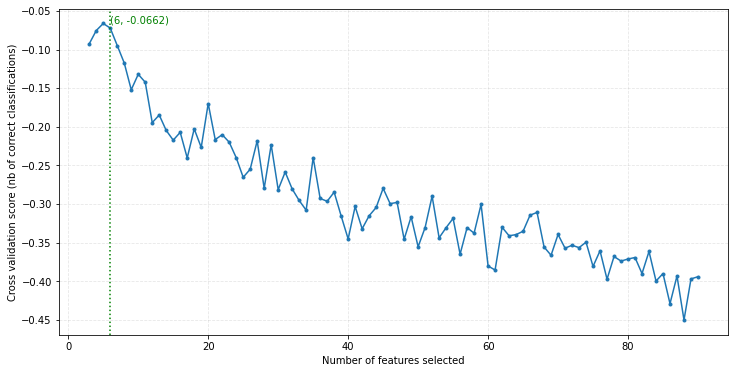

In [32]:
rf_rfecv = rfe_cv(rf_clf_best, x_train, y_train, min_features_to_select = 3)

### 5-2-3. RF - Re-train the Model using selected features only

I use RadomizedSearchCV because RandomForest generally has a lot of hyperparameters to tune

In [33]:
x_train_rf_shrink = x_train.loc[:,rf_rfecv.support_]
x_test_rf_shrink = x_test.loc[:,rf_rfecv.support_]

rf_parameters = {"n_estimators":[50,80,100,150], "max_depth":[3,5,7], "min_samples_split" :[2,5,10], "min_samples_leaf":[2,5,10]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 3, scoring = "neg_log_loss", n_iter = 20)
rf_random_search.fit(x_train_rf_shrink, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train_rf_shrink, y_train.values.ravel()))

{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 7}
0.9577714227648177


# STEP 6. Evaluation

In [34]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_rf_shrink, y_train, test_size=0.2, random_state=42)

In [35]:
# Confusion matrix => just for reference: since we are looking at the training set exclusively
from sklearn.metrics import confusion_matrix

def draw_confmat(y_true, y_pred):
    confmat = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    print("Type I error: ",round(confmat[0][1]/confmat[0].sum(),4))
    print("Type II error: ",round(confmat[1][0]/confmat[0].sum(),4))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

Type I error:  0.0303
Type II error:  0.052


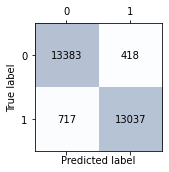

In [36]:
draw_confmat(Y_valid,rf_clf_best.predict(X_valid))

# STEP 7. Format the submission

In [37]:
# Generate the prediction using the whole training set
pd.set_option('display.float_format', lambda x: '%.3f' % x)
submission_df = pd.DataFrame({"id":test.id,"click":rf_clf_best.predict(x_test_rf_shrink)})
submission_df.to_csv("submission.csv", sep = ",", index=False)

In [38]:
submission_df.click.value_counts()

0    4411545
1     165919
Name: click, dtype: int64